# Handwritten Digits Recognition Using Shallow Neural Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [4]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [5]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[9. 1. 3. 7. 8. 0. 3. 9. 7. 0.]


In [6]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [7]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [12]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
9.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


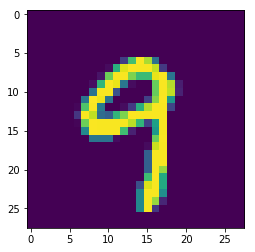

In [13]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [14]:
train_ratio = 0.9

In [15]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [16]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

In [61]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = -((Y+delta)*np.log(Y_hat+delta) + (1-Y+delta)*np.log(1-Y_hat+delta))
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(sigmoid)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(sigmoid_prime)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [47]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [67]:
model = config_multi_layer_classifier_without_regularization(train_X, train_Y, [128,32], 1)

iteration 0, current loss: 19513.877682
iteration 1, current loss: 19505.713593
iteration 2, current loss: 19497.565354
iteration 3, current loss: 19489.432892
iteration 4, current loss: 19481.316048
iteration 5, current loss: 19473.214612
iteration 6, current loss: 19465.128354
iteration 7, current loss: 19457.057038
iteration 8, current loss: 19449.000428
iteration 9, current loss: 19440.958300
iteration 10, current loss: 19432.930431
iteration 11, current loss: 19424.916605
iteration 12, current loss: 19416.916608
iteration 13, current loss: 19408.930221
iteration 14, current loss: 19400.957225
iteration 15, current loss: 19392.997392
iteration 16, current loss: 19385.050487
iteration 17, current loss: 19377.116264
iteration 18, current loss: 19369.194466
iteration 19, current loss: 19361.284828
iteration 20, current loss: 19353.387070
iteration 21, current loss: 19345.500900
iteration 22, current loss: 19337.626017
iteration 23, current loss: 19329.762107
iteration 24, current loss

iteration 198, current loss: 18094.347644
iteration 199, current loss: 18088.110999
iteration 200, current loss: 18081.884803
iteration 201, current loss: 18075.669664
iteration 202, current loss: 18069.466113
iteration 203, current loss: 18063.274596
iteration 204, current loss: 18057.095458
iteration 205, current loss: 18050.928948
iteration 206, current loss: 18044.775214
iteration 207, current loss: 18038.634317
iteration 208, current loss: 18032.506240
iteration 209, current loss: 18026.390895
iteration 210, current loss: 18020.288141
iteration 211, current loss: 18014.197792
iteration 212, current loss: 18008.119631
iteration 213, current loss: 18002.053418
iteration 214, current loss: 17995.998901
iteration 215, current loss: 17989.955821
iteration 216, current loss: 17983.923924
iteration 217, current loss: 17977.902959
iteration 218, current loss: 17971.892687
iteration 219, current loss: 17965.892881
iteration 220, current loss: 17959.903327
iteration 221, current loss: 17953

iteration 394, current loss: 16975.574023
iteration 395, current loss: 16970.421997
iteration 396, current loss: 16965.279410
iteration 397, current loss: 16960.145554
iteration 398, current loss: 16955.019719
iteration 399, current loss: 16949.901199
iteration 400, current loss: 16944.789287
iteration 401, current loss: 16939.683283
iteration 402, current loss: 16934.582497
iteration 403, current loss: 16929.486262
iteration 404, current loss: 16924.393945
iteration 405, current loss: 16919.304970
iteration 406, current loss: 16914.218844
iteration 407, current loss: 16909.135185
iteration 408, current loss: 16904.053760
iteration 409, current loss: 16898.974512
iteration 410, current loss: 16893.897591
iteration 411, current loss: 16888.823356
iteration 412, current loss: 16883.752366
iteration 413, current loss: 16878.685338
iteration 414, current loss: 16873.623087
iteration 415, current loss: 16868.566447
iteration 416, current loss: 16863.516196
iteration 417, current loss: 16858

iteration 590, current loss: 16056.763764
iteration 591, current loss: 16052.290983
iteration 592, current loss: 16047.814724
iteration 593, current loss: 16043.335494
iteration 594, current loss: 16038.853960
iteration 595, current loss: 16034.370927
iteration 596, current loss: 16029.887307
iteration 597, current loss: 16025.404076
iteration 598, current loss: 16020.922216
iteration 599, current loss: 16016.442669
iteration 600, current loss: 16011.966291
iteration 601, current loss: 16007.493821
iteration 602, current loss: 16003.025861
iteration 603, current loss: 15998.562871
iteration 604, current loss: 15994.105169
iteration 605, current loss: 15989.652942
iteration 606, current loss: 15985.206255
iteration 607, current loss: 15980.765071
iteration 608, current loss: 15976.329263
iteration 609, current loss: 15971.898635
iteration 610, current loss: 15967.472934
iteration 611, current loss: 15963.051867
iteration 612, current loss: 15958.635117
iteration 613, current loss: 15954

iteration 786, current loss: 15224.740949
iteration 787, current loss: 15220.892249
iteration 788, current loss: 15217.046013
iteration 789, current loss: 15213.202100
iteration 790, current loss: 15209.360408
iteration 791, current loss: 15205.520876
iteration 792, current loss: 15201.683491
iteration 793, current loss: 15197.848286
iteration 794, current loss: 15194.015334
iteration 795, current loss: 15190.184737
iteration 796, current loss: 15186.356615
iteration 797, current loss: 15182.531088
iteration 798, current loss: 15178.708255
iteration 799, current loss: 15174.888183
iteration 800, current loss: 15171.070891
iteration 801, current loss: 15167.256342
iteration 802, current loss: 15163.444435
iteration 803, current loss: 15159.635010
iteration 804, current loss: 15155.827847
iteration 805, current loss: 15152.022674
iteration 806, current loss: 15148.219174
iteration 807, current loss: 15144.416992
iteration 808, current loss: 15140.615743
iteration 809, current loss: 15136

iteration 982, current loss: 14519.986678
iteration 983, current loss: 14516.783359
iteration 984, current loss: 14513.583041
iteration 985, current loss: 14510.385574
iteration 986, current loss: 14507.190811
iteration 987, current loss: 14503.998623
iteration 988, current loss: 14500.808889
iteration 989, current loss: 14497.621513
iteration 990, current loss: 14494.436415
iteration 991, current loss: 14491.253544
iteration 992, current loss: 14488.072874
iteration 993, current loss: 14484.894413
iteration 994, current loss: 14481.718200
iteration 995, current loss: 14478.544312
iteration 996, current loss: 14475.372865
iteration 997, current loss: 14472.204010
iteration 998, current loss: 14469.037940
iteration 999, current loss: 14465.874882
iteration 1000, current loss: 14462.715098
iteration 1001, current loss: 14459.558875
iteration 1002, current loss: 14456.406524
iteration 1003, current loss: 14453.258366
iteration 1004, current loss: 14450.114725
iteration 1005, current loss:

iteration 1173, current loss: 13963.775223
iteration 1174, current loss: 13960.964527
iteration 1175, current loss: 13958.150467
iteration 1176, current loss: 13955.333014
iteration 1177, current loss: 13952.512173
iteration 1178, current loss: 13949.687984
iteration 1179, current loss: 13946.860530
iteration 1180, current loss: 13944.029931
iteration 1181, current loss: 13941.196349
iteration 1182, current loss: 13938.359984
iteration 1183, current loss: 13935.521069
iteration 1184, current loss: 13932.679864
iteration 1185, current loss: 13929.836651
iteration 1186, current loss: 13926.991720
iteration 1187, current loss: 13924.145364
iteration 1188, current loss: 13921.297865
iteration 1189, current loss: 13918.449488
iteration 1190, current loss: 13915.600473
iteration 1191, current loss: 13912.751028
iteration 1192, current loss: 13909.901332
iteration 1193, current loss: 13907.051530
iteration 1194, current loss: 13904.201744
iteration 1195, current loss: 13901.352076
iteration 1

iteration 1364, current loss: 13471.275272
iteration 1365, current loss: 13468.967615
iteration 1366, current loss: 13466.660199
iteration 1367, current loss: 13464.353108
iteration 1368, current loss: 13462.046450
iteration 1369, current loss: 13459.740351
iteration 1370, current loss: 13457.434960
iteration 1371, current loss: 13455.130441
iteration 1372, current loss: 13452.826973
iteration 1373, current loss: 13450.524747
iteration 1374, current loss: 13448.223961
iteration 1375, current loss: 13445.924815
iteration 1376, current loss: 13443.627510
iteration 1377, current loss: 13441.332241
iteration 1378, current loss: 13439.039196
iteration 1379, current loss: 13436.748550
iteration 1380, current loss: 13434.460466
iteration 1381, current loss: 13432.175091
iteration 1382, current loss: 13429.892555
iteration 1383, current loss: 13427.612970
iteration 1384, current loss: 13425.336432
iteration 1385, current loss: 13423.063020
iteration 1386, current loss: 13420.792795
iteration 1

iteration 1555, current loss: 13053.843376
iteration 1556, current loss: 13051.748177
iteration 1557, current loss: 13049.659705
iteration 1558, current loss: 13047.577476
iteration 1559, current loss: 13045.501033
iteration 1560, current loss: 13043.429941
iteration 1561, current loss: 13041.363794
iteration 1562, current loss: 13039.302209
iteration 1563, current loss: 13037.244834
iteration 1564, current loss: 13035.191338
iteration 1565, current loss: 13033.141417
iteration 1566, current loss: 13031.094792
iteration 1567, current loss: 13029.051208
iteration 1568, current loss: 13027.010430
iteration 1569, current loss: 13024.972250
iteration 1570, current loss: 13022.936481
iteration 1571, current loss: 13020.902960
iteration 1572, current loss: 13018.871547
iteration 1573, current loss: 13016.842130
iteration 1574, current loss: 13014.814618
iteration 1575, current loss: 13012.788950
iteration 1576, current loss: 13010.765088
iteration 1577, current loss: 13008.743022
iteration 1

iteration 1746, current loss: 12672.077078
iteration 1747, current loss: 12670.064362
iteration 1748, current loss: 12668.046813
iteration 1749, current loss: 12666.025260
iteration 1750, current loss: 12664.000702
iteration 1751, current loss: 12661.974255
iteration 1752, current loss: 12659.947090
iteration 1753, current loss: 12657.920359
iteration 1754, current loss: 12655.895127
iteration 1755, current loss: 12653.872309
iteration 1756, current loss: 12651.852630
iteration 1757, current loss: 12649.836601
iteration 1758, current loss: 12647.824520
iteration 1759, current loss: 12645.816484
iteration 1760, current loss: 12643.812412
iteration 1761, current loss: 12641.812082
iteration 1762, current loss: 12639.815160
iteration 1763, current loss: 12637.821231
iteration 1764, current loss: 12635.829830
iteration 1765, current loss: 12633.840466
iteration 1766, current loss: 12631.852640
iteration 1767, current loss: 12629.865865
iteration 1768, current loss: 12627.879675
iteration 1

iteration 1937, current loss: 12309.058203
iteration 1938, current loss: 12307.266799
iteration 1939, current loss: 12305.476516
iteration 1940, current loss: 12303.687379
iteration 1941, current loss: 12301.899421
iteration 1942, current loss: 12300.112687
iteration 1943, current loss: 12298.327236
iteration 1944, current loss: 12296.543141
iteration 1945, current loss: 12294.760484
iteration 1946, current loss: 12292.979363
iteration 1947, current loss: 12291.199883
iteration 1948, current loss: 12289.422161
iteration 1949, current loss: 12287.646313
iteration 1950, current loss: 12285.872461
iteration 1951, current loss: 12284.100722
iteration 1952, current loss: 12282.331207
iteration 1953, current loss: 12280.564018
iteration 1954, current loss: 12278.799243
iteration 1955, current loss: 12277.036956
iteration 1956, current loss: 12275.277213
iteration 1957, current loss: 12273.520053
iteration 1958, current loss: 12271.765499
iteration 1959, current loss: 12270.013553
iteration 1

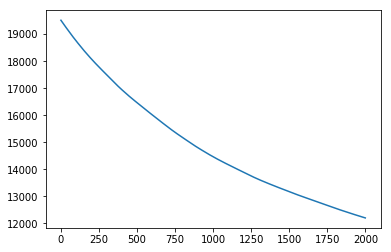

In [72]:
train_model(2000, model)
costs = model['costs']
plt.plot(costs[-2000:])
#print(W[1])

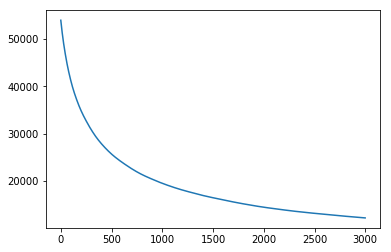

In [73]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [50]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [74]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.954735
test set accuracy: 0.888333


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [79]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [80]:
test_Y = predict(test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [81]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [82]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

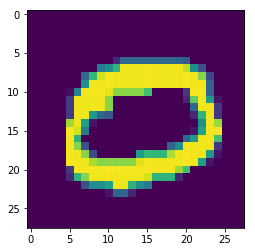

In [83]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])